# Trend Indicator Pipeline

## Configuration

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ta.trend import ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD

from arcticdb.version_store.helper import ArcticMemoryConfig
from arcticdb import Arctic

In [9]:
# Configurations
DB_PATH = '/Users/zway/Desktop/BTC_Project/DB'

## Moving Average
Simple Moving Average(SMA), Exponential Moving Average(EMA), Average Directional Index(ADX)

In [42]:
class TrendIndicatorPipeline:
    def __init__(self, lib_name='trend_indicators', store_path='arctic_store'):
        # connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_sma(self, df, window=20):
        df[f'sma_{window}'] = df['Close'].rolling(window=window).mean()
        return df

    def compute_ema(self, df, span=20):
        df[f'ema_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
        return df

    def compute_adx(self, df, window=14):
        adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=window)
        df[f'adx_{window}'] = adx.adx()
        return df
    
    def plot_indicators(self, df):
        # Plot SMA and EMA
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
        plt.plot(df.index, df['sma_20'], label='SMA 20')
        plt.plot(df.index, df['ema_20'], label='EMA 20')
        plt.title('Trend Indicators: Close Price, SMA, EMA')
        plt.xlabel('Timestamp')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot ADX
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df['adx_14'], label='ADX 14', color='purple')
        plt.axhline(25, color='gray', linestyle='--', label='Trend Threshold')
        plt.title('Average Directional Index (ADX)')
        plt.xlabel('Timestamp')
        plt.ylabel('ADX')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run(self, df: pd.DataFrame, symbol: str, sma_windows=[20], ema_spans=[20], adx_windows=[14]):
        df = df.copy()
        for w in sma_windows:
            df = self.compute_sma(df, window=w)
        for s in ema_spans:
            df = self.compute_ema(df, span=s)
        for a in adx_windows:
            df = self.compute_adx(df, window=a)

        # Save to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written trend indicators for {symbol} to ArcticDB")
        
        # Plot the indicators automatically
        self.plot_indicators(df)
        
        return df

## Momentum Indicator
Relative Strength Indicator(RSI), Stochastic Oscillator, Moving Average Convergence Divergence (MACD)

In [37]:
class MomentumIndicatorPipeline:
    def __init__(self, lib_name='momentum_indicators', store_path='arctic_store'):
        # connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_rsi(self, df, window=14):
        rsi = RSIIndicator(close=df['Close'], window=window)
        df[f'rsi_{window}'] = rsi.rsi()
        return df

    def compute_stochastic(self, df, window=14, smooth_window=3):
        stoch = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=window, smooth_window=smooth_window)
        df[f'stoch_k_{window}'] = stoch.stoch()
        df[f'stoch_d_{window}'] = stoch.stoch_signal()
        return df

    def compute_macd(self, df, fast=12, slow=26, signal=9):
        macd = MACD(close=df['Close'], window_fast=fast, window_slow=slow, window_sign=signal)
        df['macd'] = macd.macd()
        df['macd_signal'] = macd.macd_signal()
        df['macd_diff'] = macd.macd_diff()  # Histogram
        return df
    
    def plot_indicators(self, df):
        # RSI
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df['rsi_14'], label='RSI 14', color='orange')
        plt.axhline(70, color='red', linestyle='--')
        plt.axhline(30, color='green', linestyle='--')
        plt.title('Relative Strength Index (RSI)')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # Stochastic Oscillator
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df['stoch_k_14'], label='%K', color='blue')
        plt.plot(df.index, df['stoch_d_14'], label='%D', color='magenta')
        plt.axhline(80, color='red', linestyle='--')
        plt.axhline(20, color='green', linestyle='--')
        plt.title('Stochastic Oscillator')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # MACD
        plt.figure(figsize=(14, 5))
        plt.plot(df.index, df['macd'], label='MACD', color='blue')
        plt.plot(df.index, df['macd_signal'], label='Signal', color='red')
        plt.bar(df.index, df['macd_diff'], label='Histogram', color='gray', alpha=0.4)
        plt.title('MACD')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

    def run(self, df: pd.DataFrame, symbol: str, rsi_windows=[14], stoch_windows=[14], macd_params=(12, 26, 9)):
        df = df.copy()
        for w in rsi_windows:
            df = self.compute_rsi(df, window=w)
        for w in stoch_windows:
            df = self.compute_stochastic(df, window=w)
        df = self.compute_macd(df, *macd_params)

        # Save to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written momentum indicators for {symbol} to ArcticDB")
        
        # Plot the indicators automatically
        self.plot_indicators(df)
        
        return df


## Volatility Indicator
Bollinger Bands, Average True Range (ATR)

## Example Use

In [30]:
# Read dataset(s)
# Open ArcticDB libraries
ac = Arctic(f"lmdb://{DB_PATH}")
cleaned_lib = ac['cleaned_data']
engineered_lib = ac.get_library('engineered_data', create_if_missing=True)

trend_lib = ac['trend_indicators']
momentum_lib = ac['momentum_indicators']

20250613 17:12:01.628572 5082311 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[70489]


20250613 17:24:54.174787 5082311 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[70489]


[INFO] Written trend indicators for BTC_sample_1month to ArcticDB


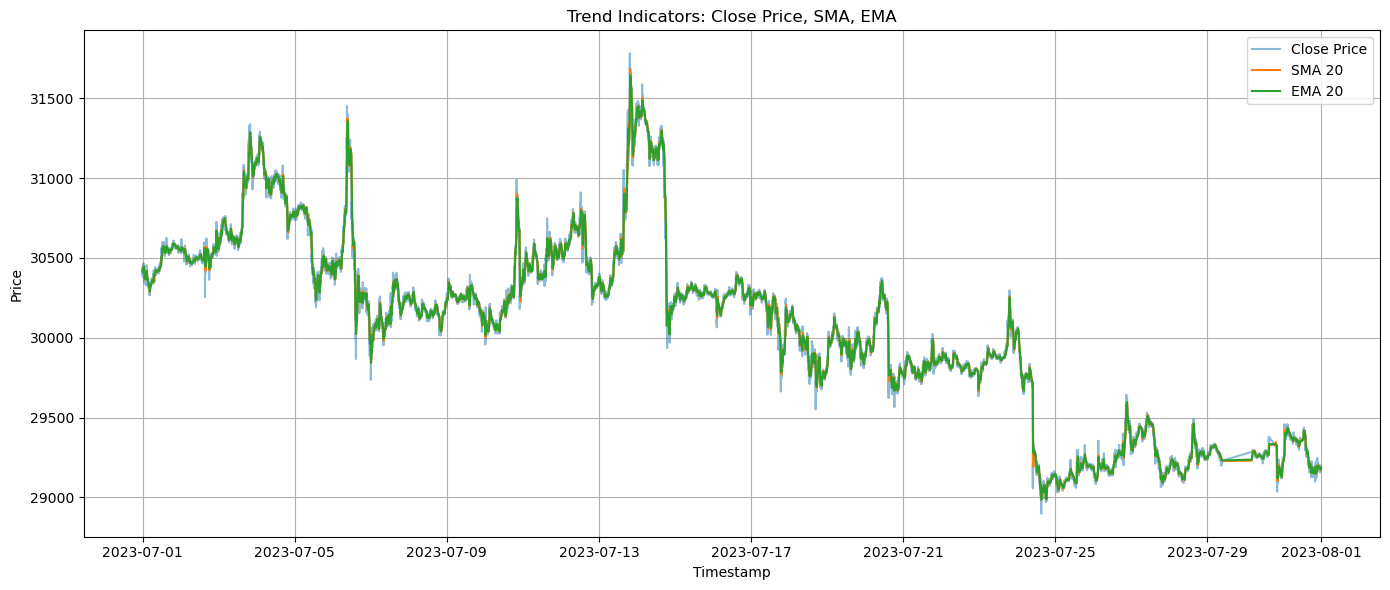

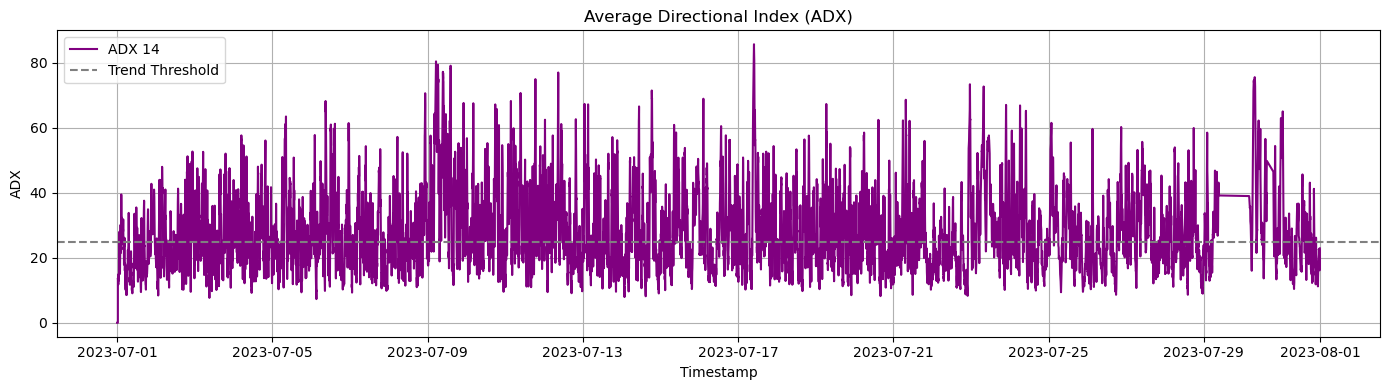

[INFO] Written momentum indicators for BTC_sample_1month to ArcticDB


20250613 17:24:54.529662 5082311 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[70489]


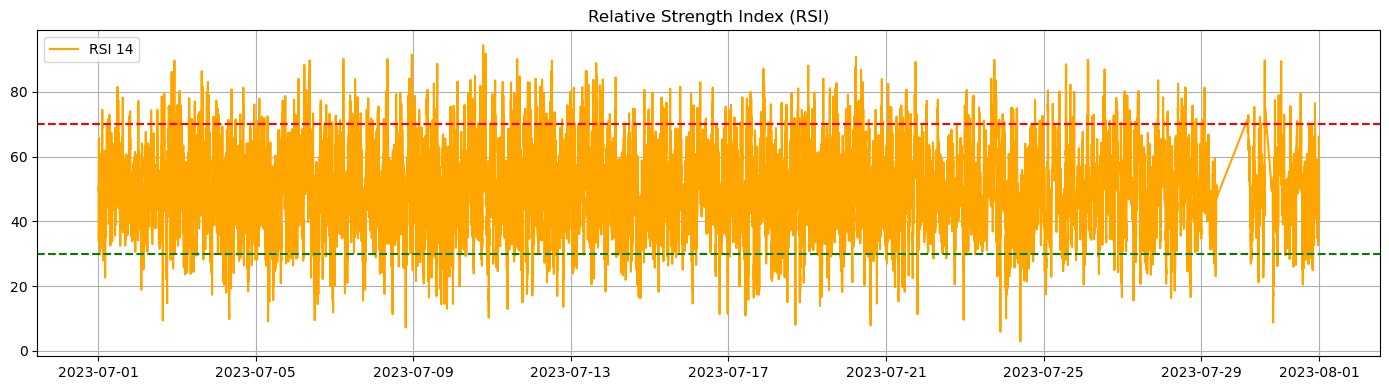

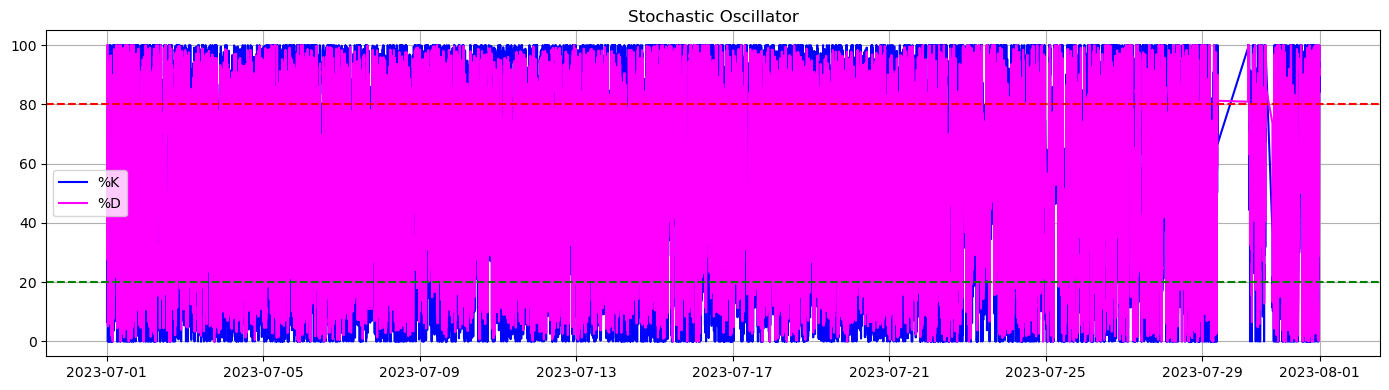

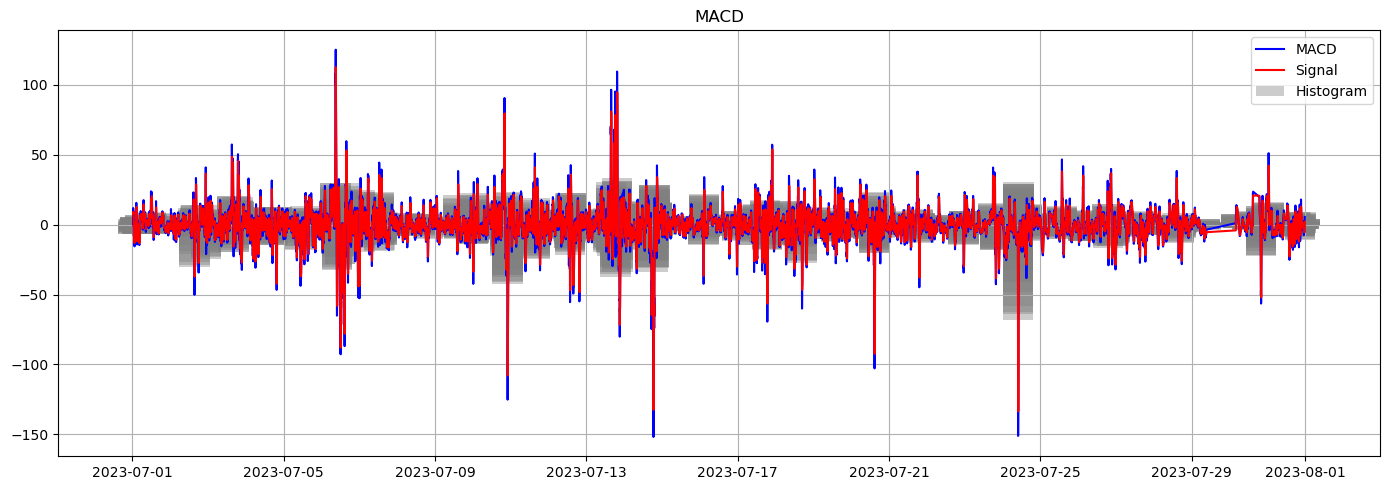

In [43]:
# sample run Moving Average
df = pd.read_csv('/Users/zway/Desktop/BTC_Project/raw_datasets/raw_sample_2023_07.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

pipeline = TrendIndicatorPipeline(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")
df_with_indicators = pipeline.run(df, symbol='BTC_sample_1month')

# sample run Momentum Indicator

momentum_pipeline = MomentumIndicatorPipeline(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")
df_momentum = momentum_pipeline.run(df, symbol='BTC_sample_1month')


In [44]:
df_trend = trend_lib.read('BTC_sample_1month').data

df_trend.head()

,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,Avg_price,sma_20,ema_20,adx_14
Timestamp,,,,,,,,,,,
2023-07-01 00:00:00,1675787,1675787,30407.1,30418.2,30407.1,30416.9,0.000027,30412.65,NaN,30416.900000,0.0
2023-07-01 00:01:00,1675788,1675788,30416.9,30416.9,30392.3,30393.2,0.000016,30404.60,NaN,30414.642857,0.0
2023-07-01 00:02:00,1675789,1675789,30393.5,30417.3,30393.5,30402.2,0.000074,30405.40,NaN,30413.457823,0.0
2023-07-01 00:03:00,1675790,1675790,30404.1,30420.8,30404.1,30413.4,0.000056,30412.45,NaN,30413.452316,0.0
2023-07-01 00:04:00,1675791,1675791,30413.6,30427.2,30413.4,30422.8,0.000039,30420.30,NaN,30414.342572,0.0


In [45]:
df_momentum = momentum_lib.read('BTC_sample_1month').data

df_momentum.head()

,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,Avg_price,rsi_14,stoch_k_14,stoch_d_14,macd,macd_signal,macd_diff
Timestamp,,,,,,,,,,,,,,
2023-07-01 00:00:00,1675787,1675787,30407.1,30418.2,30407.1,30416.9,0.000027,30412.65,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:01:00,1675788,1675788,30416.9,30416.9,30392.3,30393.2,0.000016,30404.60,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:02:00,1675789,1675789,30393.5,30417.3,30393.5,30402.2,0.000074,30405.40,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:03:00,1675790,1675790,30404.1,30420.8,30404.1,30413.4,0.000056,30412.45,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:04:00,1675791,1675791,30413.6,30427.2,30413.4,30422.8,0.000039,30420.30,NaN,NaN,NaN,NaN,NaN,NaN
